In [1]:
import os

from PIL import Image
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Data Analysis

In [2]:
img_folder = "data/CodingChallenge_v2/imgs/"
csv_path = "data/CodingChallenge_v2/car_imgs_4000.csv"

### Load images

In [3]:
# Load example image
img_example = "0aa2e141-59a9-4efa-8bbb-afaa264109c6.jpg"
img_example_path = os.path.join(img_folder, img_example)

img = Image.open(img_example_path)

In [4]:
print(img)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=674x506 at 0x150448A40>


### Load csv file

In [5]:
csv_file = pd.read_csv(csv_path)
print(csv_file.head())

                                   filename  perspective_score_hood  \
0  66ee2d88-f403-4821-a370-8a3d72e200f9.jpg                 0.27352   
1  bf7e237e-f12b-4ffc-8d79-6855cc35ea06.jpg                 0.00000   
2  4c297488-c81f-464d-92bf-1c408333a912.jpg                 0.00000   
3  6c95ad0b-fda6-42a8-a33d-b430073e1dcd.jpg                 0.00000   
4  bd806d94-4c2e-4cd2-8e02-5eaba7c7c63e.jpg                 0.00000   

   perspective_score_backdoor_left  
0                         0.439526  
1                         0.902682  
2                         0.900864  
3                         0.213162  
4                         0.818388  


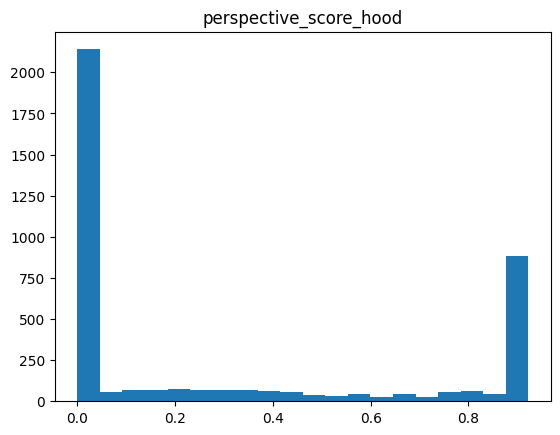

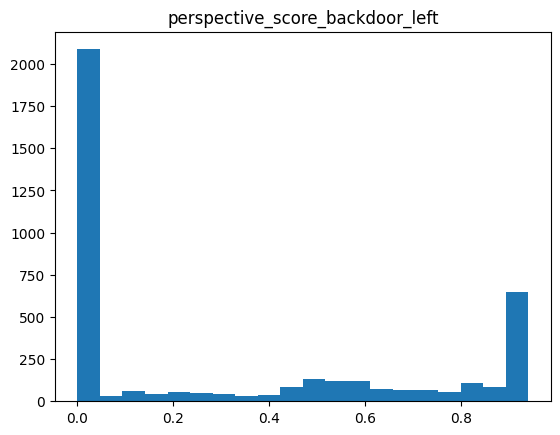

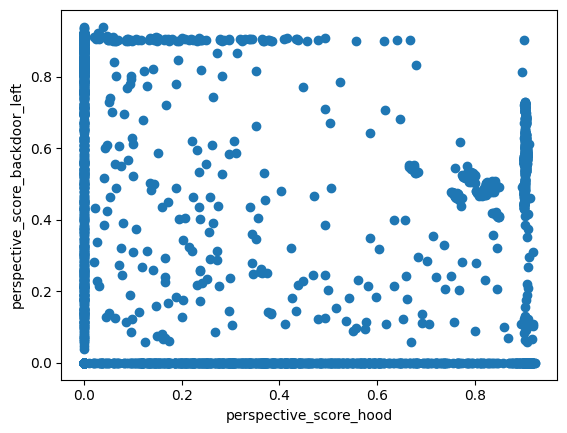

In [6]:
# Plot the distribution of perspective_score_hood and perspective_score_backdoor_left
plt.hist(csv_file["perspective_score_hood"], bins=20)
plt.title("perspective_score_hood")
plt.show()

plt.hist(csv_file["perspective_score_backdoor_left"], bins=20)
plt.title("perspective_score_backdoor_left")
plt.show()

# Now as 2d scatter plot
plt.scatter(csv_file["perspective_score_hood"], csv_file["perspective_score_backdoor_left"])
plt.xlabel("perspective_score_hood")
plt.ylabel("perspective_score_backdoor_left")
plt.show()

Besonders die Extremwerte perspective_score=0 und =1 sind sehr stark vertreten. Das ist logisch, da die meisten Bilder entweder sehr stark perspektivisch verzerrt sind oder eben nicht (direkt auf das Bauteil gerichtet). Dies könnte zu Problemen führen (änhlich einer unbalanced classification). Z.b. wird das Modell auf diesen Extremwerten häufiger iterriert/trainiert und könnte daher schlechter auf die anderen Werte generalisieren.

# Parameters

In [7]:
img_width, img_height = (674, 450)

# Modeling

In [8]:
class VisibilityPredictor(nn.Module):
    def __init__(self):
        super(VisibilityPredictor, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(56 * 84 * 128, 256)  # Adjust the input size based on your image dimensions
        self.fc2 = nn.Linear(256, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 56 * 84 * 128)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = VisibilityPredictor()
print(model)


VisibilityPredictor(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=602112, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


In [9]:
class CarPartsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        y_label = self.annotations.iloc[idx, 1:].values.astype('float32')
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(y_label)


In [10]:
transform = transforms.Compose([
    transforms.Resize((450, 674)),
    transforms.ToTensor(),
])

dataset = CarPartsDataset(csv_file=csv_path, root_dir=img_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
print(f"train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}")


train: 3200, val: 400, test: 400


### Training Loop

In [12]:
lr = 0.001
num_epochs = 20

The training loop takes approx. 356 minutes (6 hours) for 20 epochs.

Used Hardware:
- Apple MacBook 2021 (M1 Chip)

In [15]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for images, labels in tqdm(dataloader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(dataloader)
    training_losses.append(avg_epoch_loss)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            labels = labels.float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    validation_losses.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_epoch_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

  0%|          | 0/125 [00:00<?, ?it/s]

  4%|▍         | 5/125 [00:39<15:36,  7.81s/it]


KeyboardInterrupt: 

In [56]:
# Save the model
#torch.save(model.state_dict(), 'data/model/model.pth')


In [57]:
#Save the whole model
#torch.save(model, 'data/model/complete_model.pth')

In [16]:
# Load the model
model = VisibilityPredictor()
model.load_state_dict(torch.load('data/model/model.pth'))

<All keys matched successfully>

### Plot loss curve

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'training_losses' is not defined

<Figure size 1000x500 with 0 Axes>

### Testing (einzelne und multi-output Betrachtung)

WICHTIG: Die erlangten Erkenntnisse durch das Testing des Models dürfen nicht in die Modellierung einfließen. "Data Leakage" ist zu vermeiden. Erst nachdem die Modellierung abgeschlossen ist, darf das Testing durchgeführt werden.

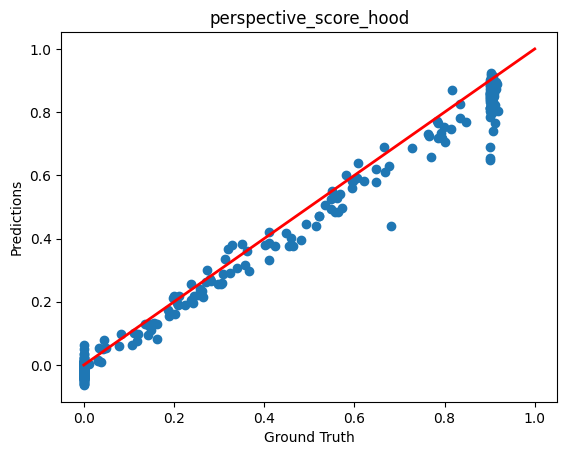

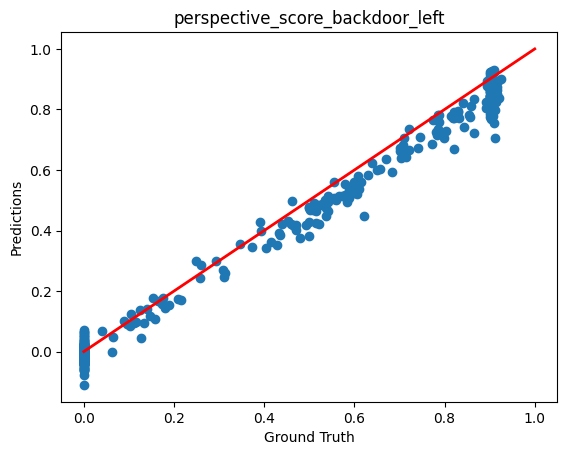

Correlation coefficient for perspective_score_hood: 0.9960
Correlation coefficient for perspective_score_backdoor_left: 0.9957


In [17]:
# Plot ground truth (x-axis) vs predictions (y-axis) and print r value
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.numpy())

y_true = np.array(y_true)   
y_pred = np.array(y_pred)

plt.scatter(y_true[:, 0], y_pred[:, 0])
# Plot red line (y=x)
plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('perspective_score_hood')
plt.show()

plt.scatter(y_true[:, 1], y_pred[:, 1])
plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('perspective_score_backdoor_left')
plt.show()

r_hood = np.corrcoef(y_true[:, 0], y_pred[:, 0])[0, 1]
r_backdoor_left = np.corrcoef(y_true[:, 1], y_pred[:, 1])[0, 1]
print(f'Correlation coefficient for perspective_score_hood: {r_hood:.4f}')
print(f'Correlation coefficient for perspective_score_backdoor_left: {r_backdoor_left:.4f}')

In [18]:
from sklearn.metrics import mean_absolute_error
mae_hood = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
mae_backdoor_left = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
print(f'MAE for perspective_score_hood: {mae_hood:.4f}')
print(f'MAE for perspective_score_backdoor_left: {mae_backdoor_left:.4f}')
mae_combined = mean_absolute_error(y_true, y_pred)
print(f'Combined MAE: {mae_combined:.4f}')

MAE for perspective_score_hood: 0.0328
MAE for perspective_score_backdoor_left: 0.0360
Combined MAE: 0.0344


In [19]:
mse_hood = mean_squared_error(y_true[:, 0], y_pred[:, 0])
mse_backdoor_left = mean_squared_error(y_true[:, 1], y_pred[:, 1])
print(f'MSE for perspective_score_hood: {mse_hood:.4f}')
print(f'MSE for perspective_score_backdoor_left: {mse_backdoor_left:.4f}')
mse_combined = mean_squared_error(y_true, y_pred)
print(f'Combined MSE: {mse_combined:.4f}')

MSE for perspective_score_hood: 0.0022
MSE for perspective_score_backdoor_left: 0.0023
Combined MSE: 0.0022


Root Mean Squared Error (RMSE)

In [20]:
rmse_hood = np.sqrt(mse_hood)
rmse_backdoor_left = np.sqrt(mse_backdoor_left)
print(f'RMSE for perspective_score_hood: {rmse_hood:.4f}')
print(f'RMSE for perspective_score_backdoor_left: {rmse_backdoor_left:.4f}')
rmse_combined = np.sqrt(mse_combined)
print(f'Combined RMSE: {rmse_combined:.4f}')

RMSE for perspective_score_hood: 0.0467
RMSE for perspective_score_backdoor_left: 0.0476
Combined RMSE: 0.0471


R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1.
R^2 = 1: The model explains all the variability of the response data around its mean.
R^2 = 0: The model explains none of the variability of the response data around its mean. 


In [21]:
# R-squared (Coefficient of Determination)
r2_hood = r2_score(torch.tensor(y_true[:, 0]), torch.tensor(y_pred[:, 0]))
r2_backdoor_left = r2_score(torch.tensor(y_true[:, 1]), torch.tensor(y_pred[:, 1]))
print(f'R-squared for perspective_score_hood: {r2_hood:.4f}')
print(f'R-squared for perspective_score_backdoor_left: {r2_backdoor_left:.4f}')
r2_combined = r2_score(y_true, y_pred, multioutput='uniform_average')
print(f'Combined R-squared: {r2_combined:.4f}')

R-squared for perspective_score_hood: 0.9847
R-squared for perspective_score_backdoor_left: 0.9838
Combined R-squared: 0.9843


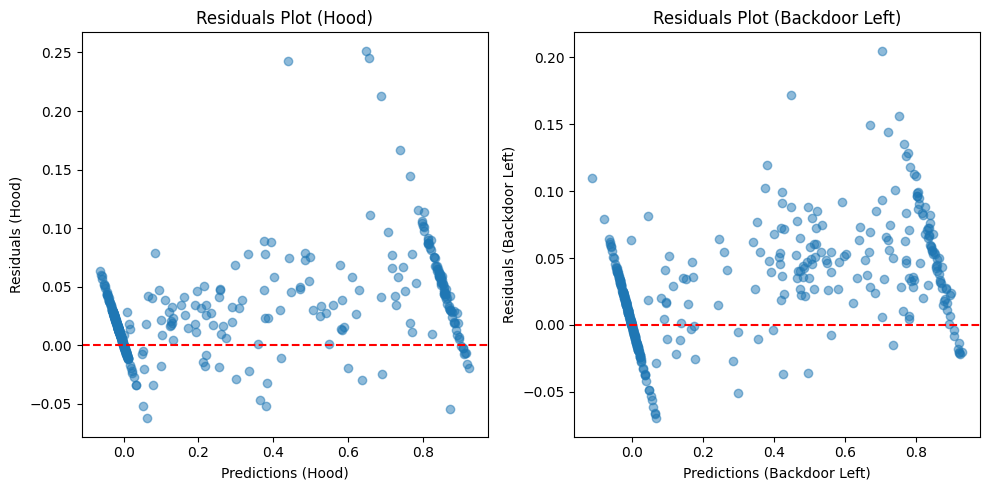

In [22]:
# Residuals for both outputs
residuals_hood = y_true[:, 0] - y_pred[:, 0]
residuals_backdoor_left = y_true[:, 1] - y_pred[:, 1]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred[:, 0], residuals_hood, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predictions (Hood)')
plt.ylabel('Residuals (Hood)')
plt.title('Residuals Plot (Hood)')

plt.subplot(1, 2, 2)
plt.scatter(y_pred[:, 1], residuals_backdoor_left, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predictions (Backdoor Left)')
plt.ylabel('Residuals (Backdoor Left)')
plt.title('Residuals Plot (Backdoor Left)')

plt.tight_layout()
plt.show()

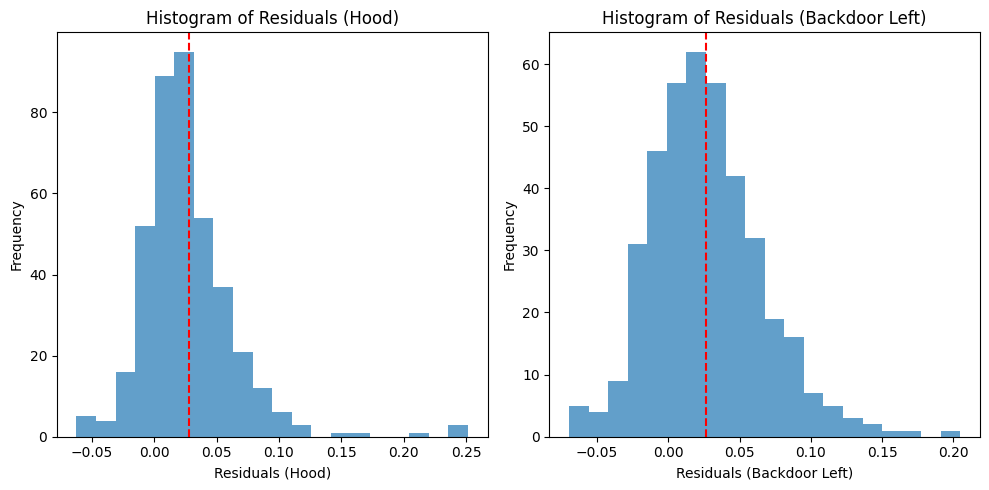

In [23]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(residuals_hood, bins=20, alpha=0.7)
#plot vertical mean line
plt.axvline(x=np.mean(residuals_hood), color='r', linestyle='--')
plt.xlabel('Residuals (Hood)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Hood)')

plt.subplot(1, 2, 2)
plt.hist(residuals_backdoor_left, bins=20, alpha=0.7)
plt.axvline(x=np.mean(residuals_backdoor_left), color='r', linestyle='--')
plt.xlabel('Residuals (Backdoor Left)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Backdoor Left)')

plt.tight_layout()
plt.show()


Residual e = y_true - y_pred <br>
Das heißt das Modell sagt einen niedrigeren Wert voraus als der tatsächliche Wert. <br>
Das konnte man bereits im true vs predic. plot sehen. <br>

# Modeling (Using pre-trained model)

Ziel: Verbesserung des Modells durch Verwendung eines pre-trained Modells. Häufig sind diese Modelle auf Klassifikationen trainiert. Daher wird das Modell auf die Regression angepasst. Um das zu erreichen, entferne ich die letzte Schicht des Modells und füge eine neue Schicht hinzu. Diese neue Schicht hat hier 2 Neuronen, da wir 2 Outputs haben. Desweitern ändern wir die Loss Function auf Mean Squared Error (MSE).

In [28]:
# use torchvision.models.resnet101 with pretrained weights
from torchvision import models

class ResNetVisibilityPredictor(nn.Module):
    def __init__(self):
        super(ResNetVisibilityPredictor, self).__init__()
        self.resnet = models.resnet101(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 2)
        
    def forward(self, x):
        return self.resnet(x)

resnet_model = ResNetVisibilityPredictor()
print(resnet_model)

ResNetVisibilityPredictor(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [30]:
# Freeze all sub-modules in resnet
for param in resnet_model.resnet.parameters():
    param.requires_grad = False

# TAKES TOO LONG TO TRAIN
# Unfreeze all sub-modules in layer4
#for param in resnet_model.resnet.layer4.parameters():
#    param.requires_grad = True

# Unfreeze the last fully connected layer
for param in resnet_model.resnet.fc.parameters():
    param.requires_grad = True

In [31]:
# Train the ResNet model
lr = 0.001
num_epochs = 20

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=lr)

training_losses = []
validation_losses = []

for epoch in range(num_epochs):

    resnet_model.train()
    epoch_loss = 0.0
    for images, labels in tqdm(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    training_losses.append(avg_epoch_loss)
    
    # Validation step
    resnet_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            labels = labels.float()
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    validation_losses.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_epoch_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

  3%|▎         | 3/100 [02:12<1:11:37, 44.30s/it]


KeyboardInterrupt: 

# Discussion

Anhand des true vs prediction scatter plots lässt sich zumindest visuell erkennen, dass die Vorhersage des perspective_score für beide Klassen tendenziell unterschätzt wird. Die Vorhersage liegt also unterhalb der optimalen Gerade mit Steigung 1 (y=x). Dadurch dass die Ausgangsschicht des Modells keine Aktivierungsfunktion hat, sind auch negative Werte in der Vorhersage möglich. Dies ist jedoch nicht sinnvoll, da perspective_score nur positive Werte annehmen kann zwischen 0 und 1.